In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

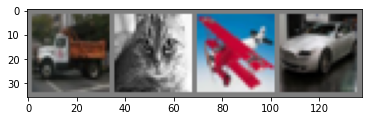

truck   cat plane   car


In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    img=img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(1296,128)
        self.fc2 = nn.Linear(128,10)
    
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
net = CNNet()
net = net.to(device)
print(net)

CNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
nn.Sequential(*list(net.children())[:4])

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
# for m in net.modules():
#     if isinstance(m,nn.Conv2d):
#         nn.init.normal_(m.weight)
#         nn.init.xavier_normal_(m.weight)
#         nn.init.kaiming_normal_(m.weight)
#         nn.init.constant_(m.bias, 0)
#     elif isinstance(m,nn.Linear):
#         nn.init.normal_(m.weight)

In [27]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):
    running_loss = 0.0
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 ==1999:
            print('[%d,%5d] loss:%.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Finished Training')

[1, 2000] loss:2.229
[1, 4000] loss:2.106
[1, 6000] loss:1.776
[1, 8000] loss:1.501
[1,10000] loss:1.425
[1,12000] loss:1.321
Finished Training
[2, 2000] loss:1.239
[2, 4000] loss:1.214
[2, 6000] loss:1.133
[2, 8000] loss:1.123
[2,10000] loss:1.102
[2,12000] loss:1.074
Finished Training
[3, 2000] loss:0.973
[3, 4000] loss:0.954
[3, 6000] loss:0.975
[3, 8000] loss:0.964
[3,10000] loss:0.938
[3,12000] loss:0.933
Finished Training
[4, 2000] loss:0.803
[4, 4000] loss:0.813
[4, 6000] loss:0.835
[4, 8000] loss:0.827
[4,10000] loss:0.821
[4,12000] loss:0.839
Finished Training
[5, 2000] loss:0.692
[5, 4000] loss:0.709
[5, 6000] loss:0.718
[5, 8000] loss:0.715
[5,10000] loss:0.732
[5,12000] loss:0.750
Finished Training
[6, 2000] loss:0.606
[6, 4000] loss:0.638
[6, 6000] loss:0.619
[6, 8000] loss:0.652
[6,10000] loss:0.664
[6,12000] loss:0.650
Finished Training
[7, 2000] loss:0.501
[7, 4000] loss:0.536
[7, 6000] loss:0.544
[7, 8000] loss:0.579
[7,10000] loss:0.580
[7,12000] loss:0.597
Finished T

In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)       
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct / total))
        

Accuracy of the network on the 10000 test images: 67 %


In [46]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] +=1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %(classes[i],100*class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 77 %
Accuracy of  bird : 63 %
Accuracy of   cat : 48 %
Accuracy of  deer : 64 %
Accuracy of   dog : 55 %
Accuracy of  frog : 71 %
Accuracy of horse : 68 %
Accuracy of  ship : 81 %
Accuracy of truck : 74 %


In [49]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,5)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,36,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.aap = nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36,10)
    
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.aap(x)
        x = x.view(x.shape[0],-1)
        x = self.fc3(x)
        return x
net = Net()
net = net.to(device)
print("net_gvp have {} parameters in total".format(sum(x.numel() for x in net.parameters())))

net_gvp have 16022 parameters in total


In [73]:
import collections
import torch

def paras_summary(input_size,model):
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split('.')[-1].split("'")[0]
            module_idx = len(summary)
            m_key = '%s-%i' %(class_name,module_idx+1)
            summary[m_key] = collections.OrderedDict()
            summary[m_key]['input_shape'] = list(input[0].size())
            summary[m_key]['input_shape'][0] = -1
            summary[m_key]['output_shape'] = list(output.size())
            summary[m_key]['output_shape'][0] = -1
            
            params = 0
            if hasattr(module,'weight'):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                if module.weight.requires_grad:
                    summary[m_key]['trainable'] = True
                else:
                    summary[m_key]['trainable'] = False
            if hasattr(module, 'bias'):
                params +=torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]['nb_params'] = params
        
        if not isinstance(module, nn.Sequential) and \
            not isinstance(module, nn.ModuleList) and \
            not (module == model):
            hooks.append(module.register_forward_hook(hook))
        
    # check if there are multiple inputs to the network
    if isinstance(input_size[0], (list, tuple)):
        x = [torch.rand(1,*in_size) for in_size in input_size]
    else:
        x = torch.rand(1,*input_size)

    #create properties
    summary = collections.OrderedDict()
    hooks = []
    # register hook
    model.apply(register_hook)
    # make a forward pass
    model(x)
    # remove these hooks
    for h in hooks:
        h.remove()

    return summary


In [74]:
net = CNNet()
input_size=[3,32,32]
paras_summary(input_size,net)

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 28, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(1216))])),
             ('MaxPool2d-2',
              OrderedDict([('input_shape', [-1, 16, 28, 28]),
                           ('output_shape', [-1, 16, 14, 14]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 14, 14]),
                           ('output_shape', [-1, 36, 12, 12]),
                           ('trainable', True),
                           ('nb_params', tensor(5220))])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 36, 12, 12]),
                           ('output_shape', [-1, 36, 6, 6]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict([('input_shape', [-1, 1296]),
 